## Hybrid coupled FEM/BEM solver for Laplace equation

In the following we use a coupling formulation presented in T. Betcke, M. Bosy and E. Burman, "Hybrid coupling of finite element and boundary integral method".

Given a domain $\Omega = \mathbb{R}^3$. We consider the unbounded problem
$$
\left\{
        \begin{array}{rcll}
            - \Delta u & = & f & \mbox{in }  \Omega \\
             |u| & \rightarrow & 0 & \mbox{while } |x| \rightarrow \infty
        \end{array}
    \right.
$$
We divide $\Omega$ into a bounded internal part $\Omega^-$ and unbounded external part $\Omega^+$ with common boundary $\Gamma$.

Then we can reformulate above problem as follows
$$
\left\{
        \begin{array}{rcll}
            - \Delta u^- + \varepsilon u& = & f & \mbox{in } \Omega^- \\
            - \Delta u^+ & = & 0 & \mbox{in } \Omega^+ \\
             u^- & = & u^+  & \mbox{on } \Gamma \\
             \partial_n u^- & = & \partial_n u^+ & \mbox{on } \Gamma \\
             |u^+| & \rightarrow & 0 & \mbox{while } |x| \rightarrow \infty
        \end{array}
    \right.
$$
where $u^i = u|_{\Omega^i}$ , $i \in \{-, +\}$, and $n$ is an outward normal vector to $\Gamma$.

The discrete interior problem for known $\widetilde{u}$ is given as
\begin{align*}
\int_{\Omega^-} \nabla u^- : \nabla v_h dx + \varepsilon \int_{\Omega^-} u^- v_h dx & \\
 - \left< \partial_n u^-, \ v_h\right>_{\Gamma } 
 - \left< u^-, \ \partial_n v_h \right>_{\Gamma} 
  + \tfrac{\tau}{h} \left< u^-,\ v_h \right>_{\Gamma} & = \int_{\Omega^-} f v_h^- dx - \left< \widetilde{u}, \ \partial_n v_h \right>_{\Gamma} + \tfrac{\tau}{h} \left<\widetilde{u},\ v_h  \right>_{\Gamma}.
\end{align*}
We are using FEniCS finite element library, hence the above formulation is more sumilar to the implementation. However for exterior problem we use matrix form, for clarity and similarity with BEMpp implementation. 
For given $\widetilde{u}$, the discrete exterior problem is given as
\begin{align*}
V \lambda  - \left( \tfrac{1}{2}Id + K \right) u^+ &= - \widetilde{u},  \\
 \left( \tfrac{1}{2} Id +  K'\right)  \lambda + \left(W + \tfrac{\tau}{h} Id\right)  u^+  &= \tfrac{\tau}{h}  \widetilde{u}.
\end{align*}
Both, the interior and exterior problems have unique solutions for given $\widetilde{u}$. In order to find $\widetilde{u}$ we solve the following problem on $\Gamma$
$$
\widetilde{u} = \tfrac12 \left(u^- + u^+ - \tfrac{h}{\tau}\left(\partial_n u^- -\lambda\right) \right).
$$

## Implementation of the exterior solver

We first implement a solver class for the exterior formulation.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import bempp.api
import numpy as np

from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator
from bempp.api.assembly.discrete_boundary_operator import InverseSparseDiscreteBoundaryOperator
from bempp.api.assembly.blocked_operator import BlockedDiscreteOperator

class ExteriorHybrid(LinearOperator):
    """
    Implement an hybrid solver for exterior Laplace problems.
    
    """
    
    def __init__(self, dirichlet_space, neumann_space, beta):
        """Instantiate the exterior solver."""
        
        self._beta = beta
        self._dirichlet_space = dirichlet_space
        self._neumann_space = neumann_space
        
        self._assemble_operator()
        
        super().__init__(np.float64, 
                         (dirichlet_space.global_dof_count, dirichlet_space.global_dof_count)
                        )
    def _assemble_operator(self):            
        """Assemble the operators."""
        from scipy.linalg import block_diag
        
        dir_identity_on_bem = bempp.api.operators.boundary.sparse.identity(
                                self._dirichlet_space, self._dirichlet_space, self._neumann_space)
        dir_identity_on_trace = bempp.api.operators.boundary.sparse.identity(
                                self._dirichlet_space, self._dirichlet_space, self._dirichlet_space)

        neu_identity_on_trace = bempp.api.operators.boundary.sparse.identity(
                                self._neumann_space, self._neumann_space, self._dirichlet_space)
        neu_identity_on_bem = bempp.api.operators.boundary.sparse.identity(
                                self._neumann_space, self._neumann_space, self._neumann_space)

        mass = bempp.api.operators.boundary.sparse.identity(
                                self._dirichlet_space, self._neumann_space, self._dirichlet_space)
        op_mass = bempp.api.operators.boundary.sparse.identity(
                                self._neumann_space, self._dirichlet_space, self._dirichlet_space)
    
        self._invmassD = InverseSparseDiscreteBoundaryOperator(dir_identity_on_trace.weak_form())
        self._invmassN = InverseSparseDiscreteBoundaryOperator(neu_identity_on_bem.weak_form())   
    
        dlp = bempp.api.operators.boundary.laplace.double_layer(
                                self._dirichlet_space, self._dirichlet_space, self._neumann_space)
        slp = bempp.api.operators.boundary.laplace.single_layer(
                                self._neumann_space, self._dirichlet_space, self._neumann_space)
        adlp = bempp.api.operators.boundary.laplace.adjoint_double_layer(
                                self._neumann_space, self._neumann_space, self._dirichlet_space)
        hslp = bempp.api.operators.boundary.laplace.hypersingular(
                                self._dirichlet_space, self._neumann_space, self._dirichlet_space)

        self._identD = dir_identity_on_trace.weak_form().A 
        self._identDN = dir_identity_on_bem.weak_form().A  
        self._identN = op_mass.weak_form().A    
        
        
        blocks = [[None,None],[None,None]]
        blocks[0][0] =  slp.weak_form()
        blocks[0][1] = -(0.5 * dir_identity_on_bem + dlp).weak_form()

        blocks[1][0] =  (0.5 * neu_identity_on_trace + adlp).weak_form()
        blocks[1][1] =  (beta * mass + hslp).weak_form()  
        
        self._matrixBEM = BlockedDiscreteOperator(np.array(blocks))
            
    def _matvec(self, arr):
        """
        Implement the exterior part of the Schur complement
        Takes coefficients in Bempp ordering and returns trace values in Bempp ordering.
        """
        sol = self.solve(arr)
        return self._identN @ sol[:self._neumann_space.global_dof_count] + self._beta * self._identD @ sol[self._neumann_space.global_dof_count:]
    
    def solve(self, arr):
        """Solve the exterior problem."""
        
        ########################## Preconditioner
        def apply_mass(x):
            """Apply the block diagonal preconditioner"""
            m1 = self._invmassN.shape[0]
            m2 = self._invmassD.shape[0]
            n1 = self._invmassN.shape[1]
            n2 = self._invmassD.shape[1]

            res1 = self._invmassN.dot(x[:n1])
            res2 = self._invmassD.dot(x[n1:n1+n2])
            return np.concatenate([res1, res2])

        mass_shape = (self._invmassD.shape[0] + self._invmassN.shape[0], self._invmassD.shape[1] + self._invmassN.shape[1])
        Mass = LinearOperator(mass_shape, apply_mass, dtype=np.dtype('float64'))
        
        rhs = np.concatenate([-(self._identDN @ arr), self._beta * self._identD @ arr])
        solBEM, _info = gmres(self._matrixBEM , rhs, M = Mass, tol = tol)
        return solBEM 

## Implementation of the interior solver

For the interior formulation we use the FEniCS finite element library.

In [2]:
class InteriorHybrid(LinearOperator):
    """Implement the FeniCS interior solver"""
    
    def __init__(self, fenics_space, epsilon, beta, nor, rhs_f, u_Dir, trace_matrix):
        """Initialise the interior solver."""
        
        self._fenics_space = fenics_space
        self._epsilon = epsilon
        self._beta = beta
        self._nor = nor
        self._rhs_f = rhs_f
        self._u_Dir = u_Dir
        self._trace_matrix = trace_matrix
        
        self._u_D = dolfin.Function(self._fenics_space)
        
        self._assemble_operator()
        
        super().__init__(np.float64, (trace_matrix.shape[0], trace_matrix.shape[0]))
        
    def _assemble_operator(self):
        """Assemble the operators."""
        
        import dolfin
        from bempp.api.external.fenics import FenicsOperator
        
        u = dolfin.TrialFunction(self._fenics_space)
        v = dolfin.TestFunction(self._fenics_space)
        
        self._u_D.interpolate(self._u_Dir)
        
        self._stiffness = dolfin.assemble((dolfin.dot(dolfin.grad(u),dolfin.grad(v))) * dolfin.dx() \
                            + self._epsilon*u*v*dolfin.dx() \
                            - dolfin.dot(dolfin.grad(v),self._nor)*u*dolfin.ds \
                            - dolfin.dot(dolfin.grad(u),self._nor)*v*dolfin.ds \
                            + self._beta*v*u*dolfin.ds() )
    
        self._B =  FenicsOperator(dolfin.dot(dolfin.grad(u),self._nor)*v*dolfin.ds() 
                        - self._beta*v*u*dolfin.ds()).weak_form().A
        self._BT = dolfin.assemble(dolfin.dot(dolfin.grad(v),self._nor)*u*dolfin.ds() 
                        - self._beta*v*u*dolfin.ds())
        
        self._FEM_rhs = v*self._rhs_f*dolfin.dx()  + self._epsilon*v*self._u_D*dolfin.dx() 
    
        self._rhs_fem = dolfin.assemble(self._FEM_rhs)
        
        
    def _matvec(self, arr):
        """
        Implement the interior part of the Schur complement
        Takes coefficients in Bempp ordering and returns trace values in Bempp ordering.
        """
        coef = (trace_matrix.T @ arr)
        lhs = dolfin.Function(self._fenics_space)
        lhs.vector()[:] = np.ascontiguousarray(np.real(coef))
        coeffs = self._BT * lhs.vector() 
#         print(coeffs)
        return -trace_matrix * (self._B @ self.solve(coeffs))
    
    def get_b(self):
        """Return rhs vector"""
        return -trace_matrix * (self._B @ self.solve(self._rhs_fem)) 
    
    def solve(self, arr):
        """Solve the interior problem. """
        
        u = dolfin.Function(self._fenics_space)
        U = u.vector()
        dolfin.solve(self._stiffness, U, arr, "cg", "amg") # Use solvers and preconditioners avalable in FEniCS
        return np.array(U)
    
    def solution(self, arr):
        """Calculate the solution of the interior problem. """
        
        coef = (trace_matrix.T * arr)
        lhs = dolfin.Function(self._fenics_space)
        lhs.vector()[:] = np.ascontiguousarray((coef))
        coeffs = self._rhs_fem - self._BT * lhs.vector()
        return self.solve(coeffs)

## Combined Solver

The following operator implements the overall coup

In [3]:
class CombinedOperator(LinearOperator):
    """The overall system operator."""
    
    def __init__(self, t_plus, t_minus, C):
        """Initialise the operator."""
        
        self._t_plus = t_plus
        self._t_minus = t_minus
        self._C = C
        
        super().__init__(np.float64, (t_plus.shape[0], t_plus.shape[0]) )
        
    def _matvec(self, arr):
        """Perform a matvec."""
        
        tilde_u = arr[:].ravel()
        
        return (0.5*self._t_minus @ tilde_u + self._C @ tilde_u- 0.5*self._t_plus @ tilde_u)

We can now implement the overall solver. Once the problem is solved we have the trace variable. We now applied the interior and exterior solvers one more time to obtain from the correct values of the solution u.

In [4]:
import dolfin
from dolfin_utils.meshconvert import meshconvert
from bempp.api.external import fenics
from scipy.sparse.linalg import cg
import pylab as plt
import time

theta = 10.0   
epsilon = 1.   
 
tol = 1e-8

FEM_u_error = []
BEM_u_error = []
BEM_lambda_error = []

mesh_size = []
iter_num = []
time_solve = []

#################################### Example 1 #############################################    
@bempp.api.real_callable
def f(x, n, d, res):
    res[0] = 1/(4.0*np.pi*np.sqrt(x[0]**2+x[1]**2+x[2]**2)) 
    
@bempp.api.real_callable    
def g(x, n, d, res):
    grad = np.array([
            -x[0]/(4.0*np.pi*(x[0]**2+x[1]**2+x[2]**2)**(3.0/2.0)),
            -x[1]/(4.0*np.pi*(x[0]**2+x[1]**2+x[2]**2)**(3.0/2.0)),
            -x[2]/(4.0*np.pi*(x[0]**2+x[1]**2+x[2]**2)**(3.0/2.0))
        ])
    res[0] = np.dot(grad, n)

u_Dir = dolfin.Expression('-(x[0]*x[0]+x[1]*x[1]+x[2]*x[2] - 3)/(8*pi)', degree=2)
rhs_f = dolfin.Constant(3./(4.*np.pi))
    
# ################################### Example 2 #############################################    
# @bempp.api.real_callable
# def f(x, n, d, res):
#     res[0] = 1/(np.sqrt(x[0]**2+x[1]**2+x[2]**2)) 
    
# @bempp.api.real_callable
# def g(x, n, d, res):
#     grad = np.array([
#             -x[0]/((x[0]**2+x[1]**2+x[2]**2)**(3.0/2.0)),
#             -x[1]/((x[0]**2+x[1]**2+x[2]**2)**(3.0/2.0)),
#             -x[2]/((x[0]**2+x[1]**2+x[2]**2)**(3.0/2.0))
#         ])
#     res[0] = np.dot(grad, n)

# u_Dir = dolfin.Expression('sin(pi*(x[0]*x[0]+x[1]*x[1]+x[2]*x[2]))/(2*pi) + cos(pi*(x[0]*x[0]+x[1]*x[1]+x[2]*x[2]))/(2*pi) + (2*pi+1)/(2*pi)', degree=2) 
# rhs_f = dolfin.Expression('sin(pi*(x[0]*x[0]+x[1]*x[1]+x[2]*x[2]))*(2*pi*(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])+3) + cos(pi*(x[0]*x[0]+x[1]*x[1]+x[2]*x[2]))*(2*pi*(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])-3)', degree=2) 
    
grid_size = [6, 5, 4, 3, 2]#, 1]

for m in grid_size:
    ######################### Mesh and spaces ##################################
    mesh_file = "Sphere_h_0_"+format(m)+".msh"
    meshconvert.convert2xml(mesh_file, "mesh.xml", iformat=None)
    mesh = dolfin.Mesh("mesh.xml")           

    nor = dolfin.FacetNormal(mesh) 

    fenics_space = dolfin.FunctionSpace(mesh, "CG", 1)

    # The following command returns from a FEniCS space the
    # corresponding boundary space as Bempp object and a
    # sparse matrix that takes a FEniCS coefficient vector
    # and returns the corresponding boundary coefficients in
    # Bempp ordering.
    dirichlet_space, trace_matrix = \
        fenics.fenics_to_bempp_trace_data(fenics_space)
    neumann_space = bempp.api.function_space(dirichlet_space.grid, "DP", 0) 
    
    u_fun = bempp.api.GridFunction(dirichlet_space, fun=f)
    lambda_fun = bempp.api.GridFunction(neumann_space, fun=g)
    
    ###################### Stabilisation parameter ######################
    hmax = dirichlet_space.grid.maximum_element_diameter
        
    mesh_size.append(hmax)

    beta = theta/hmax
    
    ###################### Assembling the system ######################
    start = time.time()     
    
    t_minus = InteriorHybrid(fenics_space, epsilon, beta, nor, rhs_f, u_Dir, trace_matrix)
    t_plus  = ExteriorHybrid(dirichlet_space, neumann_space, beta)
    
    C =  (beta*bempp.api.operators.boundary.sparse.identity(
                                    dirichlet_space, dirichlet_space, dirichlet_space).weak_form())
    
    lhs = CombinedOperator(t_plus, t_minus, C)
    rhs = 0.5*t_minus.get_b()
    
    end = time.time()
    set_time = (end - start)    
    
    
    ###################### Solving the system ######################
    it_count = 0
    def count_iterations(x):
        global it_count
        it_count += 1
    
    start = time.time()     
    sol, _info = cg(lhs, rhs, atol = tol, callback=count_iterations)
    end = time.time()
    curr_time = set_time + (end - start)    

    iter_num.append(it_count)
    time_solve.append(curr_time)
    print("Number of iterations: {0}".format(it_count))
    
    
    ###################### Calculating solutions ######################
    
    # First compute the interior solution
    u_minus = dolfin.Function(fenics_space)
    u_minus_coeffs = t_minus.solution(sol)  
    u_minus.vector()[:] = np.ascontiguousarray(np.real(u_minus_coeffs))

    # Now compute the exterior solution
    sol_bem = t_plus.solve(sol) 
    p_plus = sol_bem[:neumann_space.global_dof_count]
    u_plus = sol_bem[neumann_space.global_dof_count:]

    dirichlet_fun = bempp.api.GridFunction(dirichlet_space, coefficients=u_plus)
    neumann_fun = bempp.api.GridFunction(neumann_space, coefficients=p_plus)

    
    ###################### Calculationg errors ######################
    error = (t_minus._u_D-u_minus)**2*dolfin.dx()
    L2_error = dolfin.assemble(error)
    
    e_fun = [dirichlet_fun-u_fun,neumann_fun-lambda_fun]

    FEM_u_error.append(np.sqrt(L2_error))
    BEM_u_error.append(e_fun[0].l2_norm())
    BEM_lambda_error.append(e_fun[1].l2_norm())    
    

Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 55 vertices
Found all vertices
Expecting 104 cells
Found all cells
Conversion done


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations: 8
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 165 vertices
Found all vertices
Expecting 502 cells
Found all cells
Conversion done


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations: 12
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 242 vertices
Found all vertices
Expecting 763 cells
Found all cells
Conversion done
Number of iterations: 12
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 361 vertices
Found all vertices
Expecting 1260 cells
Found all cells
Conversion done
Number of iterations: 13
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 735 vertices
Found all vertices
Expecting 2979 cells
Found all cells
Conversion done
Number of iterations: 14


The rest is plotting.

## Convergence plot

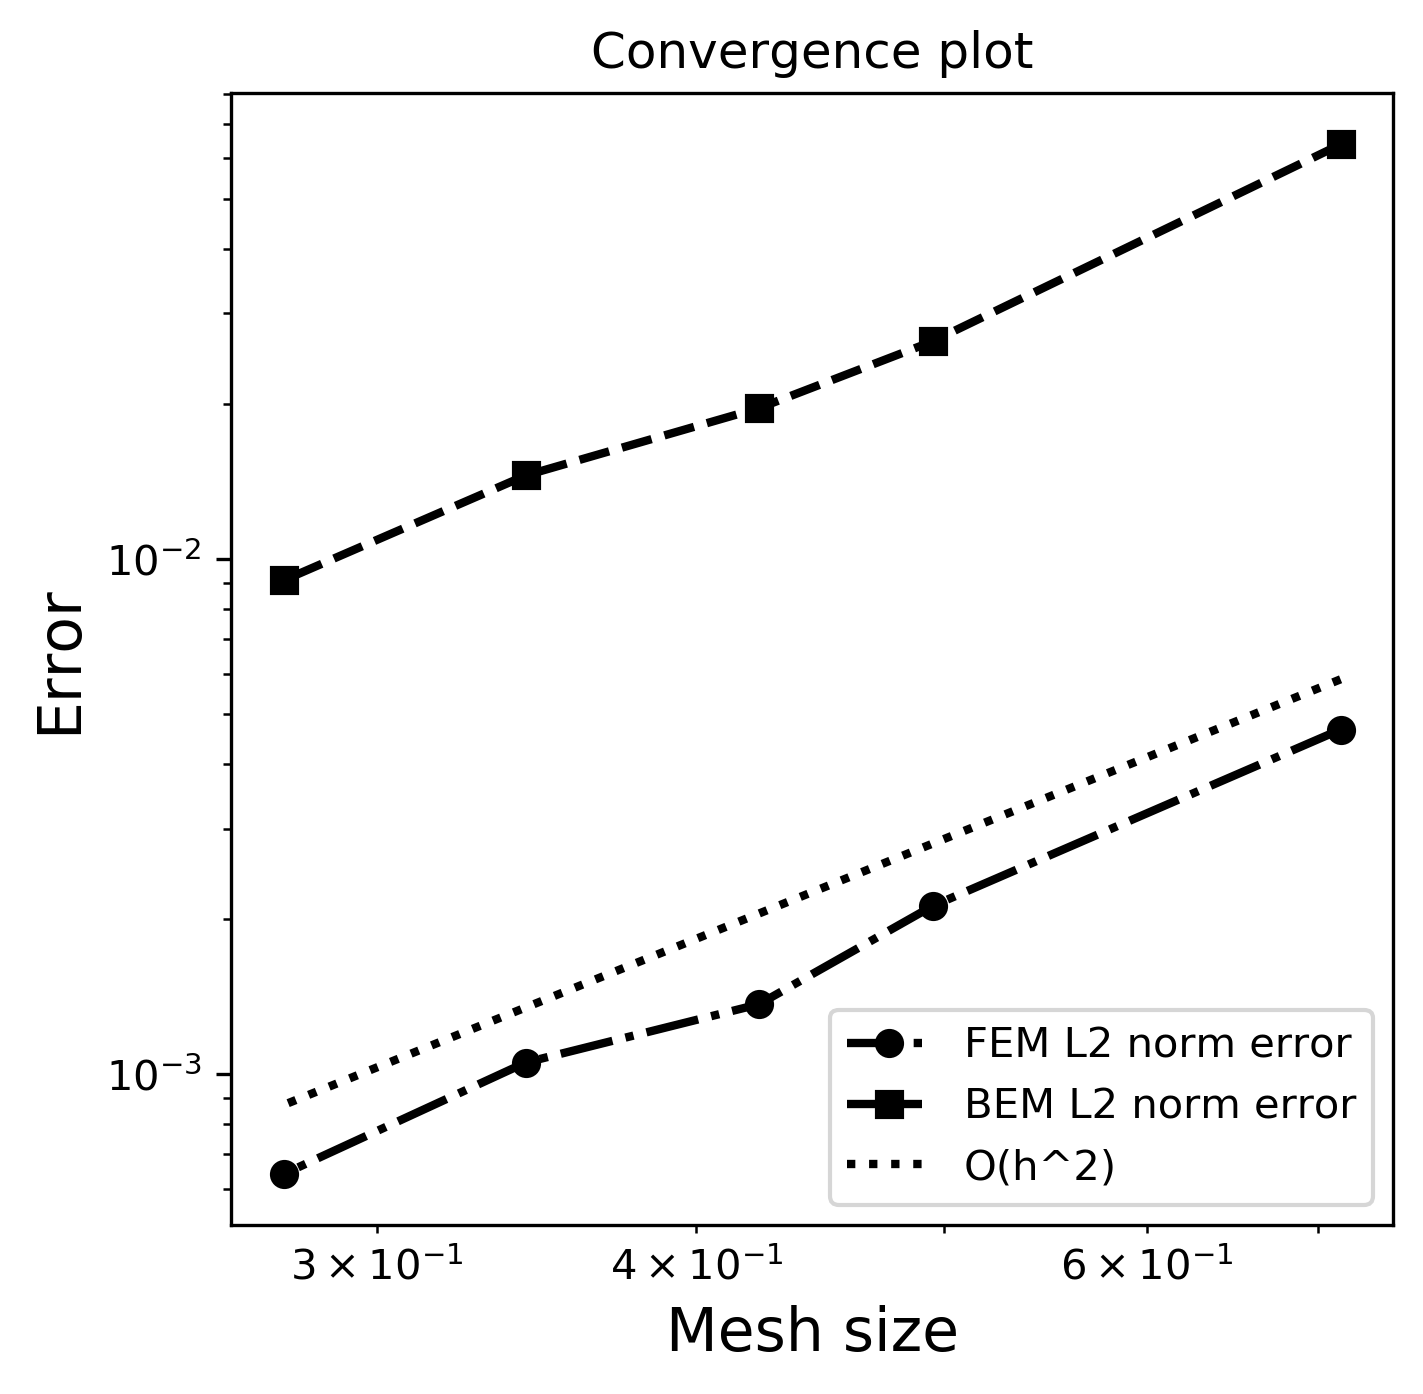

In [5]:
from operator import add
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)
inv_mesh_size =  np.true_divide(1, mesh_size)

mult = abs(FEM_u_error[len(mesh_size)//2]/mesh_size[len(mesh_size)//2])
o_mesh_size = np.multiply(mult, mesh_size)

mesh_pow_2 = np.multiply(mesh_size, mesh_size)
mult = 1.5*abs(FEM_u_error[len(mesh_size)//2]/mesh_pow_2[len(mesh_size)//2])
o_mesh_pow_2 = np.multiply(mult, mesh_pow_2)

plt.figure( figsize=(5, 5), dpi=300)
plt.loglog(mesh_size, FEM_u_error, 'ko-.', linewidth=2, label='FEM L2 norm error')
# plt.loglog(mesh_size, BEM_u_error, 'ks--', linewidth=2, label='BEM L2 norm error')
# plt.loglog(mesh_size, BEM_lambda_error, 'ks:', linewidth=2, label='BEM H1 semi-norm error')
plt.loglog(mesh_size, list(map(add, BEM_u_error, BEM_lambda_error)), 'ks--', linewidth=2, label='BEM L2 norm error')
# plt.loglog(mesh_size, o_mesh_size, 'k:', linewidth=1, label='O(h)')
plt.loglog(mesh_size, o_mesh_pow_2, 'k:', linewidth=2, label='O(h^2)')
plt.legend(loc='lower right')
plt.title('Convergence plot')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Error', fontsize='x-large')
plt.show()

## Iteration count

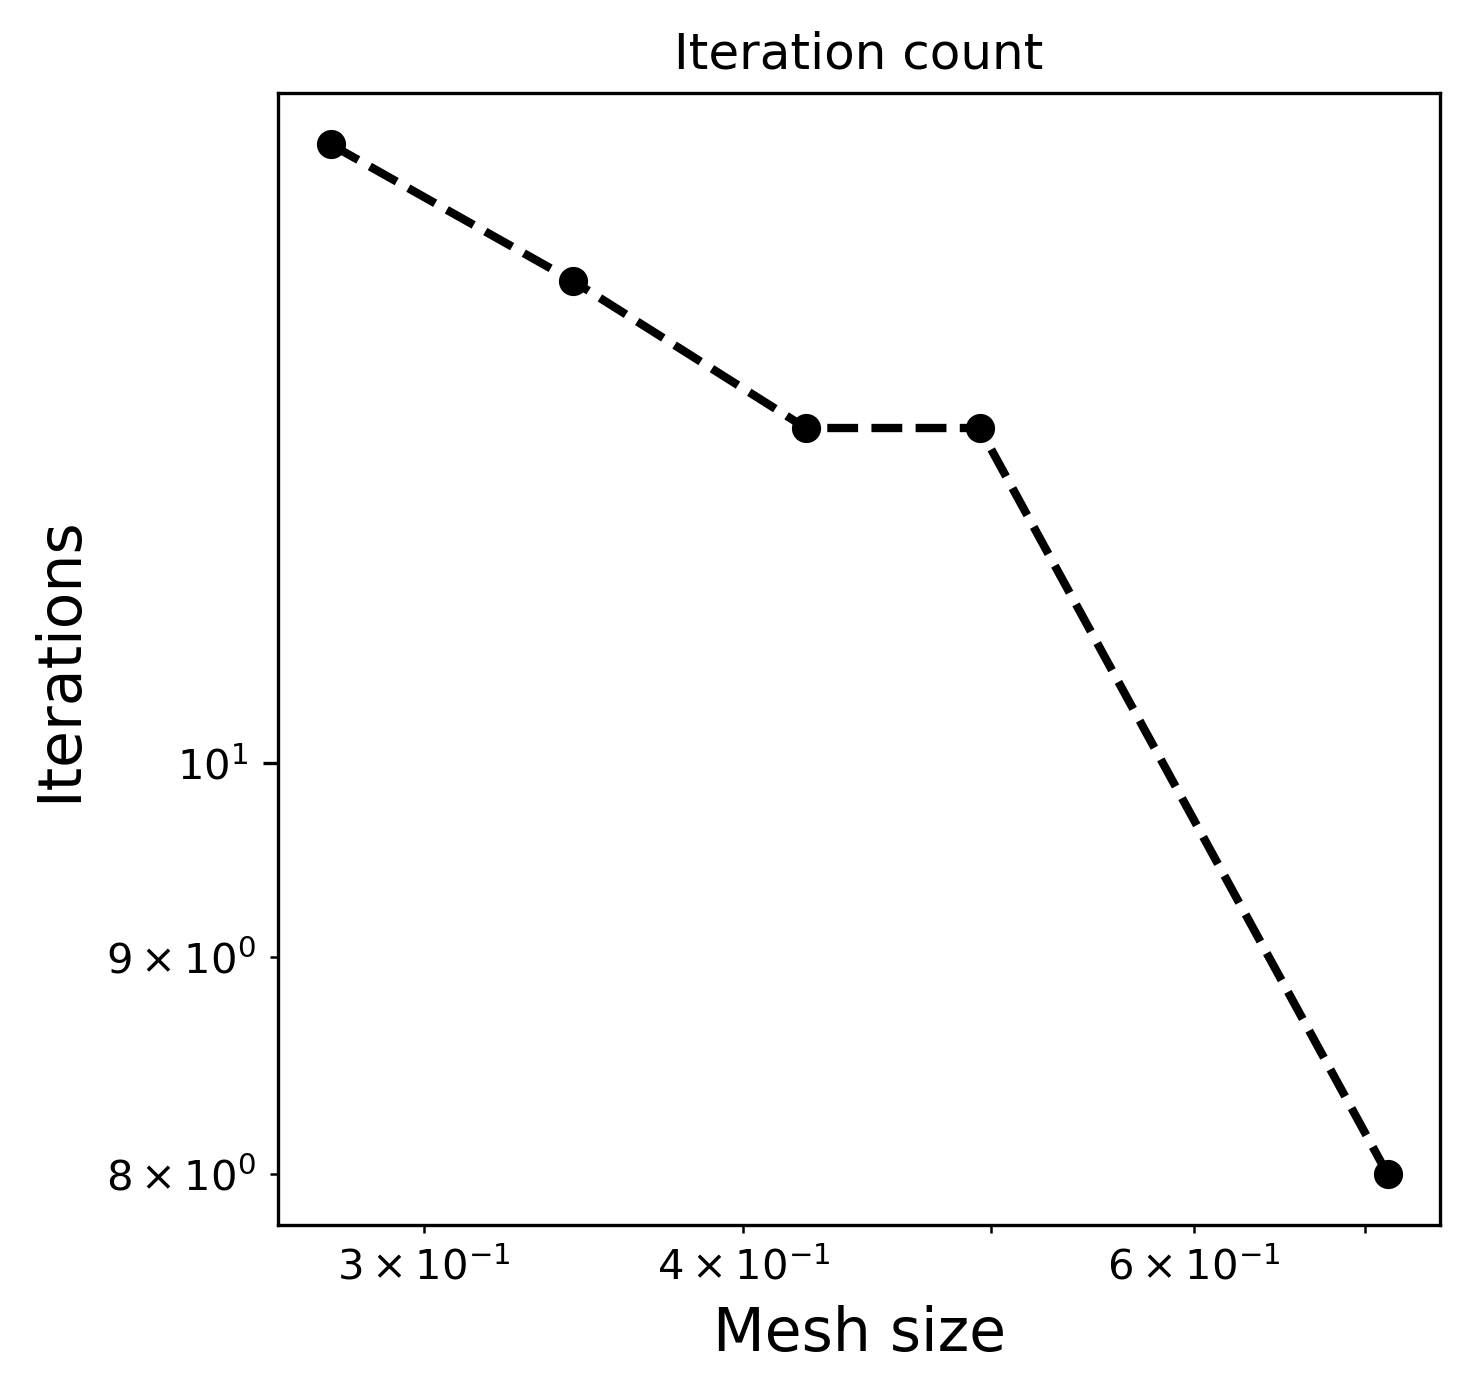

In [6]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

plt.figure( figsize=(5, 5), dpi=300)
plt.loglog(mesh_size, iter_num, 'ko--', linewidth=2)
plt.title('Iteration count')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Iterations', fontsize='x-large')
plt.show()

## Computational cost

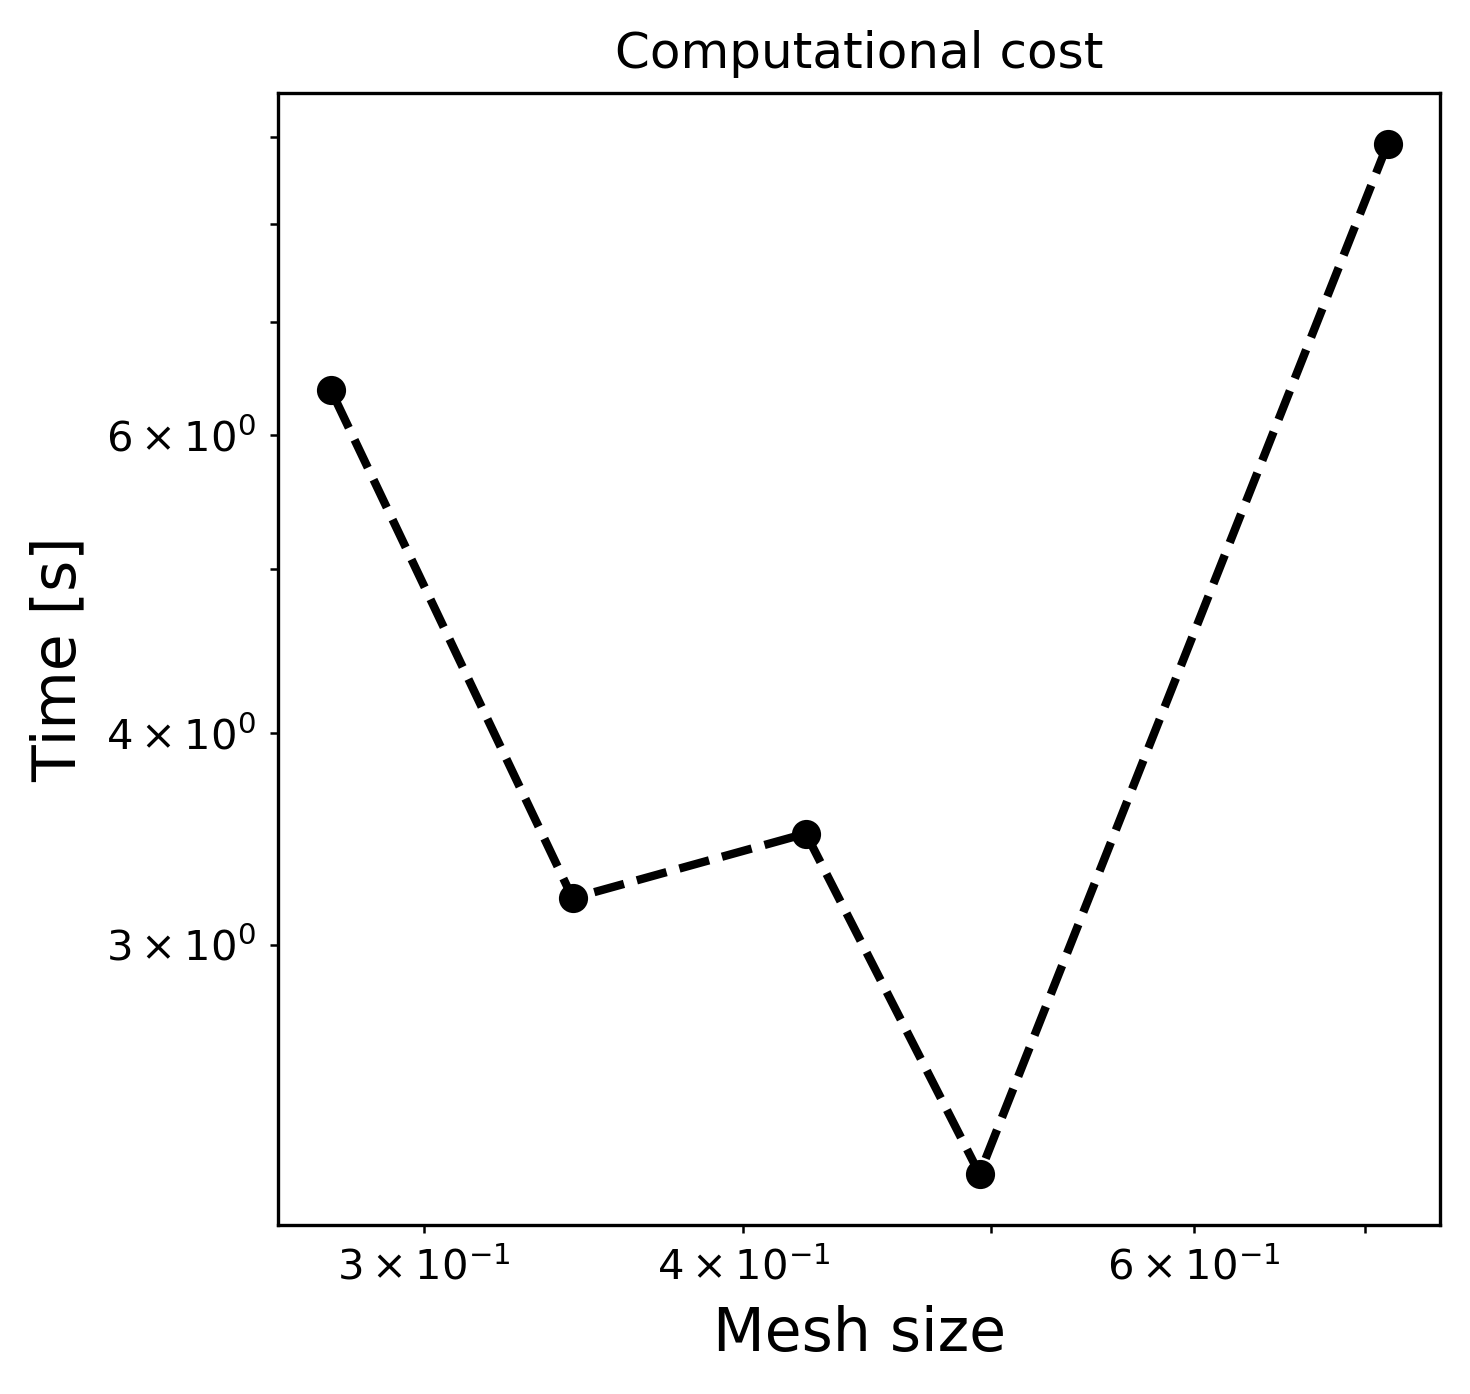

In [7]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

plt.figure( figsize=(5, 5), dpi=300)
plt.loglog(mesh_size, time_solve, 'ko--', linewidth=2)
plt.title('Computational cost')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Time [s]', fontsize='x-large')
plt.show()